In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

from sklearn.model_selection import train_test_split

from src.dataset.kay import load_dataset
from src.utils.util import prepare_fmri_data

from src.ml import FMRIClassifierConfig

from src.ml.test import test_model
from src.ml.train import train_model
from src.ml.dataset import FMRIDataset
from src.ml.model import FMRIClassifier
from src.ml.utils import plot_loss_acc_curves, generate_score_report

In [2]:
%matplotlib inline
sns.set_style("darkgrid")

title_size = 16
params = {
    "legend.fontsize": 14,
    "axes.labelsize": title_size - 2,
    "axes.titlesize": title_size,
    "xtick.labelsize": title_size - 4,
    "ytick.labelsize": title_size - 4,
    "axes.titlepad": 1.5 * title_size,
}

plt.rcParams.update(params)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("We're using =>", device)

We're using => cuda


In [4]:
config = FMRIClassifierConfig()

## Load Data

In [5]:
all_data = load_dataset(data_path="./../data/")

In [6]:
x_trainval, y_trainval = prepare_fmri_data(
    all_data=all_data,
    data_subset="train",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

# split trainval into train and val data
x_train, x_val, y_train, y_val = train_test_split(
    x_trainval,
    y_trainval,
    test_size=config.validation_dataset_size,
    stratify=y_trainval,
    random_state=42,
)


x_test, y_test = prepare_fmri_data(
    all_data=all_data,
    data_subset="test",
    class_ignore_list=config.class_ignore_list,
    label_level=config.label_level,
    roi_select_list=config.roi_select_list,
)

In [7]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape

((1393, 8427), (1393,), (349, 8427), (349,), (119, 8427), (119,))

In [8]:
class2idx = {k: i for i, k in enumerate(np.unique(y_trainval))}
idx2class = {v: k for k, v in class2idx.items()}

## Create Dataset and Dataloader

In [9]:
train_dataset = FMRIDataset(x_data=x_train, y_data=y_train, class2idx=class2idx)

val_dataset = FMRIDataset(x_data=x_val, y_data=y_val, class2idx=class2idx)

test_dataset = FMRIDataset(x_data=x_test, y_data=y_test, class2idx=class2idx)

train_loader = DataLoader(
    dataset=train_dataset, shuffle=True, batch_size=config.batch_size
)
val_loader = DataLoader(
    dataset=val_dataset, shuffle=False, batch_size=config.batch_size
)
test_loader = DataLoader(
    dataset=test_dataset, shuffle=False, batch_size=config.batch_size
)

## Initialize Model

In [10]:
model = FMRIClassifier(
    num_features=x_train.shape[1], num_classes=len(class2idx)
)
model.to(device)

epochs = config.epochs
criterion = nn.CrossEntropyLoss()  # weight=class_weights.to(device)
optimizer = optim.AdamW(model.parameters(), lr=config.learning_rate)

## Train Model

In [11]:
loss_stats, acc_stats = train_model(
    model=model,
    epochs=epochs,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    criterion=criterion,
    device=device,
    save_model_path="./../models/fmri_classifier/fmri_classifier_model.pth",
)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 01/20: | Train Loss: 1.80121 | Val Loss: 1.59938 | Train Acc: 26.182% | Val Acc: 23.000%
Epoch 02/20: | Train Loss: 1.71438 | Val Loss: 1.58004 | Train Acc: 29.364% | Val Acc: 25.333%
Epoch 03/20: | Train Loss: 1.70680 | Val Loss: 1.56696 | Train Acc: 29.636% | Val Acc: 29.333%
Epoch 04/20: | Train Loss: 1.68585 | Val Loss: 1.56007 | Train Acc: 31.545% | Val Acc: 31.667%
Epoch 05/20: | Train Loss: 1.65825 | Val Loss: 1.55300 | Train Acc: 32.091% | Val Acc: 35.000%
Epoch 06/20: | Train Loss: 1.65070 | Val Loss: 1.54721 | Train Acc: 31.273% | Val Acc: 40.333%
Epoch 07/20: | Train Loss: 1.61524 | Val Loss: 1.54550 | Train Acc: 32.455% | Val Acc: 40.667%
Epoch 08/20: | Train Loss: 1.56749 | Val Loss: 1.54099 | Train Acc: 36.000% | Val Acc: 40.333%
Epoch 09/20: | Train Loss: 1.57091 | Val Loss: 1.53502 | Train Acc: 35.273% | Val Acc: 40.667%
Epoch 10/20: | Train Loss: 1.58048 | Val Loss: 1.52180 | Train Acc: 34.818% | Val Acc: 43.667%
Epoch 11/20: | Train Loss: 1.55584 | Val Loss: 1.5

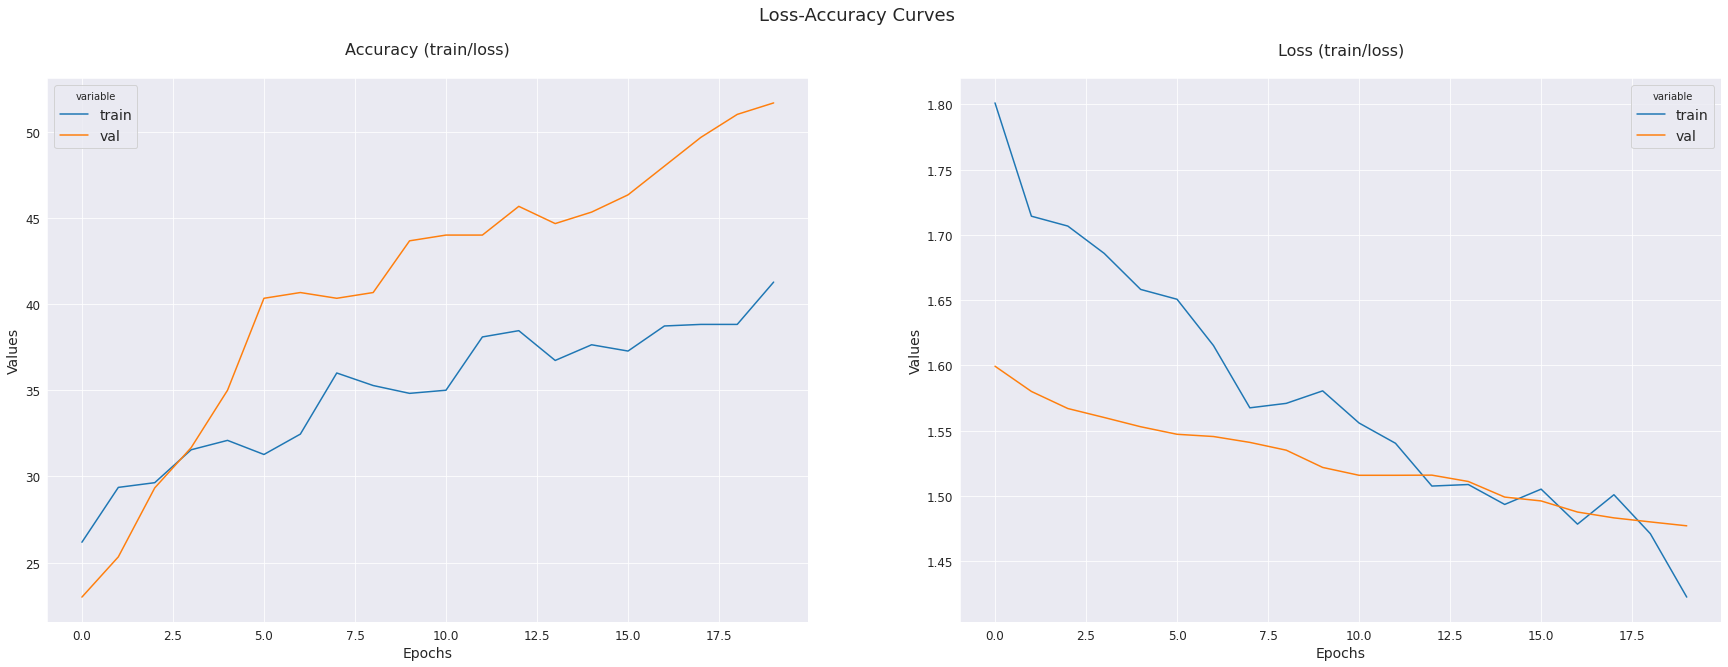

In [12]:
plot_loss_acc_curves(loss_stats, acc_stats)

## Test Model

In [13]:
y_true_list, y_pred_list = test_model(model, test_loader, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.50      0.55        54
           1       0.52      0.66      0.58        50
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00         1
           4       0.20      0.20      0.20        10

    accuracy                           0.52       119
   macro avg       0.26      0.27      0.26       119
weighted avg       0.51      0.52      0.51       119






/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/akshaj/miniconda3/envs/decoding-thoughts/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(av

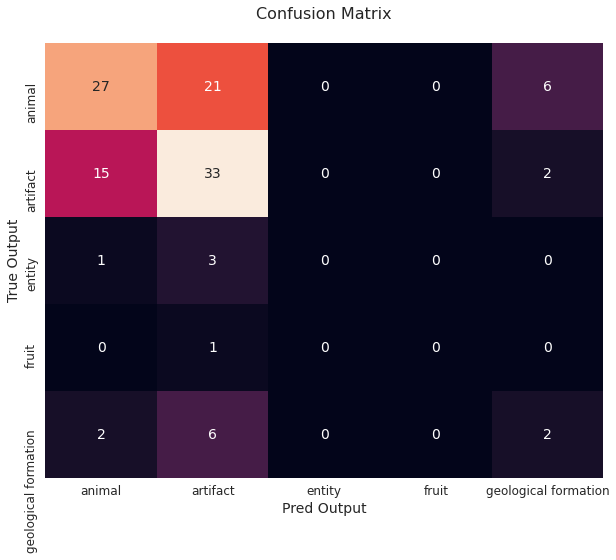

In [14]:
generate_score_report(y_true=y_true_list, y_pred=y_pred_list, idx2class=idx2class)